In [4]:
#geant4_name = "newMIP_smeared_20keV_200cells_FPCD.hdf5"
geant4_name = "../G4_5x5_10kDiscrete.h5"
geant4_name = "../G4_smeared.h5"

#diffusion_name = "GSGM.h5"
diffusion_name = "../GSGM_5x5_Discrete.h5"
diffusion_name = "../GSGM_128MLP_2truth.h5"

g4 = h5py.File(geant4_name, 'r')
dfsn = h5py.File(diffusion_name,'r')

g4.keys()
#dfsn.keys()

nevts = 100_000

### Very Important MASK, for zero-supressed Point Clouds

In [5]:
G4_MASK = g4['hcal_cells'][:nevts,:,-1]!=0
G4_MASK = np.ravel(G4_MASK)

DF_MASK = dfsn['cell_features'][:nevts,:,-1]!=0
DF_MASK = np.ravel(DF_MASK)

In [6]:
from matplotlib import gridspec
def SetGrid(ratio=True):
        fig = plt.figure(figsize=(9, 9))
        if ratio:
            gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
            gs.update(wspace=0.025, hspace=0.1)
        else:
            gs = gridspec.GridSpec(1, 1)
        return fig,gs

In [7]:
def plot_macro(g4_data,df_data,binning,label,ax0_yminor=0.005):
    
    xmin = np.min(binning)
    xmax = np.max(binning)
    xN = len(binning)
    xWidth = (binning[1]-binning[0])/2
    
    fig,gs = SetGrid()
    ax0 = plt.subplot(gs[0])
    plt.xticks(fontsize=0)
    ax1 = plt.subplot(gs[1],sharex=ax0)

    g4_counts = ax0.hist(g4_data,bins=binning,label="GEANT4",
                     color="mediumslateblue",histtype='step',
                     linestyle='dotted',linewidth=2,density=True)
    df_counts = np.histogram(df_data,bins=binning,density=True)
    g4_counts = np.asarray(g4_counts[0])
    
    #Calculations
    g4_counts = np.where(g4_counts == 0, 1.0, g4_counts)
    df_counts = np.asarray(df_counts[0])
    bin_centers = np.linspace(xmin+xWidth,xmax-xWidth,xN-1)
    emd = EMD(g4_data,df_data)
    

    ax0.hist(df_data,bins=binning,label="FPCD, EMD: %.2E"%(emd),
                     color="orange",histtype='step',linewidth=2,
                     linestyle="dashed",density=True)
    
    ax0.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
    ax0.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
    ax0.set_ylabel("Normalized entries",fontsize=20)
    
    ax0.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

    ax0.legend()
    ax0.set_xlim(xmin,xmax)


    _ = ax1.scatter(bin_centers,(g4_counts-df_counts)/g4_counts*100,label="FPCD",
                    edgecolors="orange",facecolors='none',linewidth=2,s=60)

    #Ticks
    ax1.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

    ax1.set_ylim(-50.1,50.1)
    ax1.set_ylabel("Difference (%)",fontsize=20)
    ax1.set_xlabel(label,fontsize=20)

    #Diff Lines
    ax1.hlines(10,xmin,xmax,color='red',linestyle = '--',alpha=0.75,linewidth=1)
    ax1.hlines(0,xmin,xmax,color='red',linestyle = '-',alpha=0.75,linewidth=1)
    ax1.hlines(-10,xmin,xmax,color='red',linestyle = '--',alpha=0.75,linewidth=1)
    
    return ax0,ax1

In [8]:
def plot_avgE_macro(g4_data,df_data,g4_E,df_E,binning,label,ax0_yminor=0.005):
    
    xmin = np.min(binning)
    xmax = np.max(binning)
    xN = len(binning)
    xWidth = (binning[1]-binning[0])/2
    
    fig,gs = SetGrid()
    ax0 = plt.subplot(gs[0])
    plt.xticks(fontsize=0)
    ax1 = plt.subplot(gs[1],sharex=ax0)

    
    g4_counts = np.histogram(g4_data,bins=binning,density=False)
    df_counts = np.histogram(df_data,bins=binning,density=False)
    
    g4_Esum   = np.histogram(g4_data,bins=binning,weights=g4_E,density=False)
    df_Esum   = np.histogram(df_data,bins=binning,weights=df_E,density=False)
    
    g4_counts = np.asarray(g4_counts[0])
    df_counts = np.asarray(df_counts[0])
    g4_counts = np.where(g4_counts == 0, 1.0, g4_counts)
    df_counts = np.where(df_counts == 0, 1.0, df_counts)
    
    g4_Esum   = np.asarray(g4_Esum[0])
    df_Esum   = np.asarray(df_Esum[0])
    
    g4_avgE = g4_Esum/g4_counts
    df_avgE = df_Esum/df_counts
    
    g4_avgE = np.where(g4_avgE == 0, 1.0, g4_avgE)

    #Calculations
    bin_centers = np.linspace(xmin+xWidth,xmax-xWidth,xN-1)
    emd = EMD(g4_data,df_data,g4_E,df_E)
    

    
    ax0.step(bin_centers,g4_avgE,label="GEANT4",
                     color="mediumslateblue",
                     linestyle='dotted',linewidth=2)
    
    ax0.step(bin_centers,df_avgE,label="FPCD, EMD: %.2E"%(emd),
                     color="orange",linewidth=2,
                     linestyle="dashed")
    
    ax0.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
    ax0.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
    ax0.set_ylabel("Mean Energy [GeV]",fontsize=20)
    
    ax0.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

    ax0.legend()
    ax0.set_xlim(xmin,xmax)


    _ = ax1.scatter(bin_centers,(g4_avgE-df_avgE)/g4_avgE*100,label="FPCD",
                    edgecolors="orange",facecolors='none',linewidth=2,s=60)

    #Ticks
    ax1.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
    ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(4))
    ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator(4))

    ax1.set_ylim(-50.1,50.1)
    ax1.set_ylabel("Difference (%)",fontsize=20)
    ax1.set_xlabel(label,fontsize=20)

    #Diff Lines
    ax1.hlines(10,xmin,xmax,color='red',linestyle = '--',alpha=0.75,linewidth=1)
    ax1.hlines(0,xmin,xmax,color='red',linestyle = '-',alpha=0.75,linewidth=1)
    ax1.hlines(-10,xmin,xmax,color='red',linestyle = '--',alpha=0.75,linewidth=1)
    
    return ax0,ax1

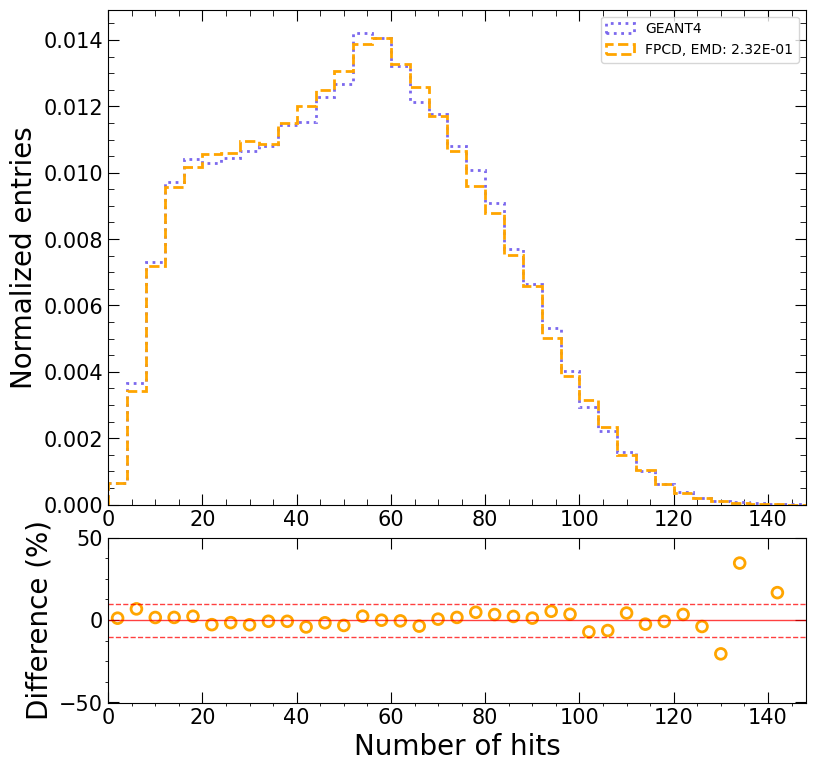

In [9]:
g4_NCells = np.ravel(g4['cluster'][:nevts,-1])
dfsn_NCells = np.ravel(dfsn['cluster_features'][:,-1])
hit_bins = np.linspace(0,148,38)
ax0,ax1 = plot_macro(g4_NCells,dfsn_NCells,hit_bins,"Number of hits")
plt.savefig("Hits_PointClouds.pdf")

## XYZ Binning

In [5]:
discrete_name = "../G4_Nominal.hdf5" #Any standard Geant4 simulation (no smearing applied)
bin_dict = bining.get_bin_dict( discrete_name )

In [7]:
print(bin_dict.keys())
print(len(bin_dict['edgesX']))
print(bin_dict['edgesX'])
print(bin_dict['centersX'])
print(bin_dict['widthX'],"mm")

dict_keys(['centersX', 'edgesX', 'widthX', 'centersY', 'edgesY', 'widthY', 'centersZ', 'edgesZ', 'widthZ', 'widthE'])
56
[-2750. -2650. -2550. -2450. -2350. -2250. -2150. -2050. -1950. -1850.
 -1750. -1650. -1550. -1450. -1350. -1250. -1150. -1050.  -950.  -850.
  -750.  -650.  -550.  -450.  -350.  -250.  -150.   -50.    50.   150.
   250.   350.   450.   550.   650.   750.   850.   950.  1050.  1150.
  1250.  1350.  1450.  1550.  1650.  1750.  1850.  1950.  2050.  2150.
  2250.  2350.  2450.  2550.  2650.  2750.]
[-2700. -2600. -2500. -2400. -2300. -2200. -2100. -2000. -1900. -1800.
 -1700. -1600. -1500. -1400. -1300. -1200. -1100. -1000.  -900.  -800.
  -700.  -600.  -500.  -400.  -300.  -200.  -100.     0.   100.   200.
   300.   400.   500.   600.   700.   800.   900.  1000.  1100.  1200.
  1300.  1400.  1500.  1600.  1700.  1800.  1900.  2000.  2100.  2200.
  2300.  2400.  2500.  2600.  2700.]
100.0 mm


In [1]:
print(bin_dict.keys())
print(len(bin_dict['edgesY']))
print(bin_dict['centersY'])
print(bin_dict['widthY'],"mm")

NameError: name 'bin_dict' is not defined

In [13]:
print(bin_dict.keys())
print(len(bin_dict['edgesZ']))
print(bin_dict['edgesZ'])
print(bin_dict['widthZ'],"mm")

dict_keys(['centersX', 'edgesX', 'widthX', 'centersY', 'edgesY', 'widthY', 'centersZ', 'edgesZ', 'widthZ', 'widthE'])
56
[3809.8 3833.2 3856.6 3880.  3903.4 3926.8 3950.2 3973.6 3997.  4020.4
 4043.8 4067.2 4090.6 4114.  4137.4 4160.8 4184.2 4207.6 4231.  4254.4
 4277.8 4301.2 4324.6 4348.  4371.4 4394.8 4418.2 4441.6 4465.  4488.4
 4511.8 4535.2 4558.6 4582.  4605.4 4628.8 4652.2 4675.6 4699.  4722.4
 4745.8 4769.2 4792.6 4816.  4839.4 4862.8 4886.2 4909.6 4933.  4956.4
 4979.8 5003.2 5026.6 5050.  5073.4 5096.8]
23.4 mm


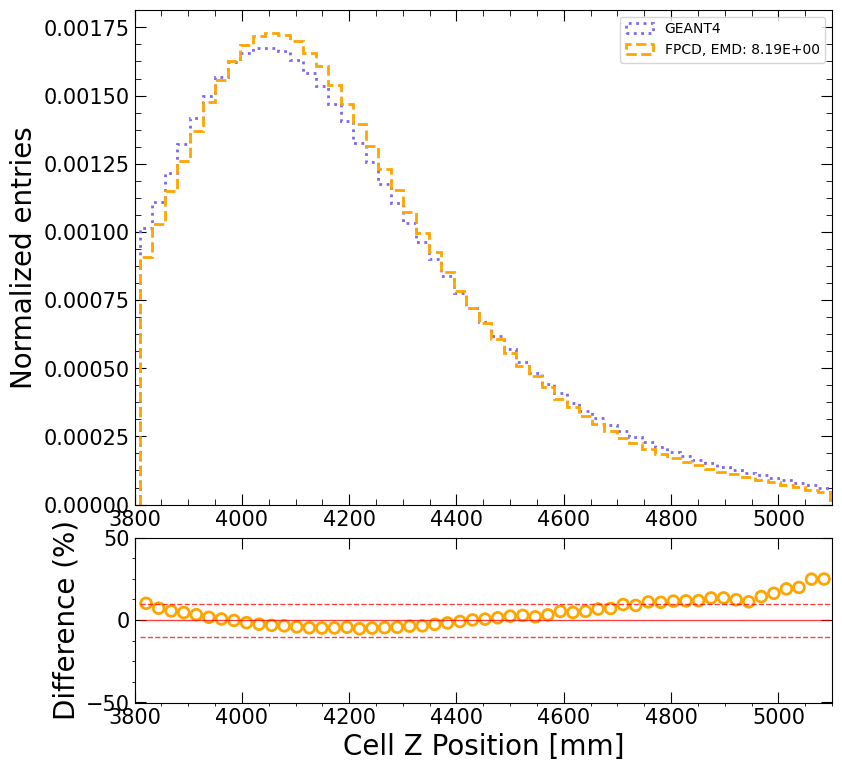

In [16]:
g4_cellsZ = np.ravel(g4['hcal_cells'][:nevts,:,3])[G4_MASK]
dfsn_cellsZ = np.ravel(dfsn['cell_features'][:,:,3])[DF_MASK]

#cellsZ_bins = np.linspace(3800,5000,30)
cellsZ_bins = bin_dict['edgesZ']
ax0,ax1 = plot_macro(g4_cellsZ,dfsn_cellsZ,cellsZ_bins,"Cell Z Position [mm]")
plt.xlim(3800,5100)
plt.savefig("Z_PointClouds.pdf")

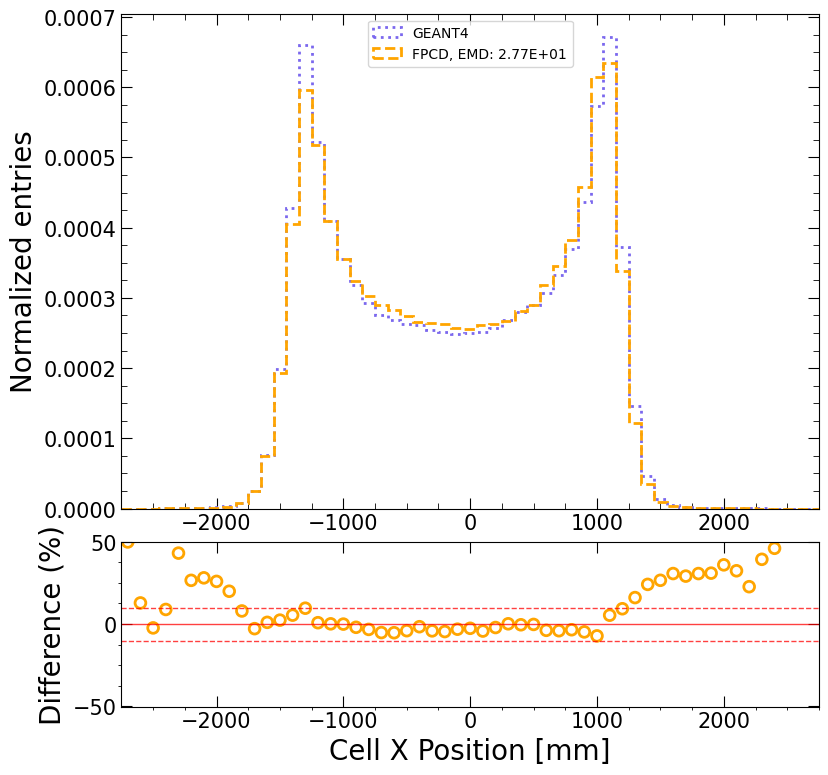

In [18]:
g4_cellsX = np.ravel(g4['hcal_cells'][:nevts,:,1])[G4_MASK]
dfsn_cellsX = np.ravel(dfsn['cell_features'][:,:,1])[DF_MASK]

#cellsX_bins = np.linspace(-2000,2000,40)
cellsX_bins = bin_dict['edgesX']
ax0,ax1 = plot_macro(g4_cellsX,dfsn_cellsX,cellsX_bins,"Cell X Position [mm]")
ax0.legend(loc="upper center")
plt.savefig("X_PointClouds.pdf")

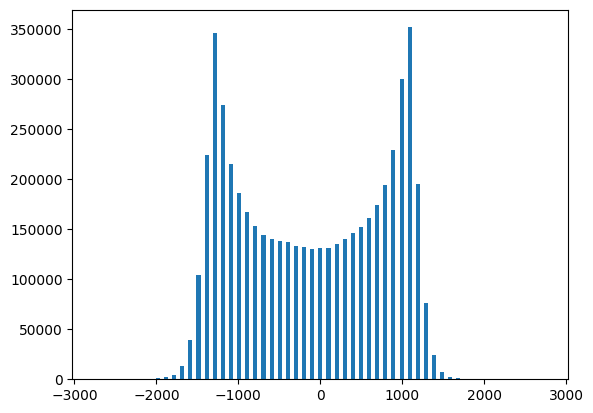

In [21]:
g4 = h5py.File(discrete_name, 'r')
g4_cellsX = np.ravel(g4['hcal_cells'][:nevts,:,1])[G4_MASK]
dfsn_cellsX = np.ravel(dfsn['cell_features'][:,:,1])[DF_MASK]

#cellsX_bins = np.linspace(-2000,2000,40)
cellsX_bins = np.linspace(-2750,2750,112)
#cellsX_bins = bin_dict['edgesX']
#ax0,ax1 = plot_macro(g4_cellsX,dfsn_cellsX,cellsX_bins,"Cell X Position [mm]")
plt.hist(g4_cellsX,bins=cellsX_bins)
ax0.legend(loc="upper center")
plt.savefig("X_PointClouds.pdf")

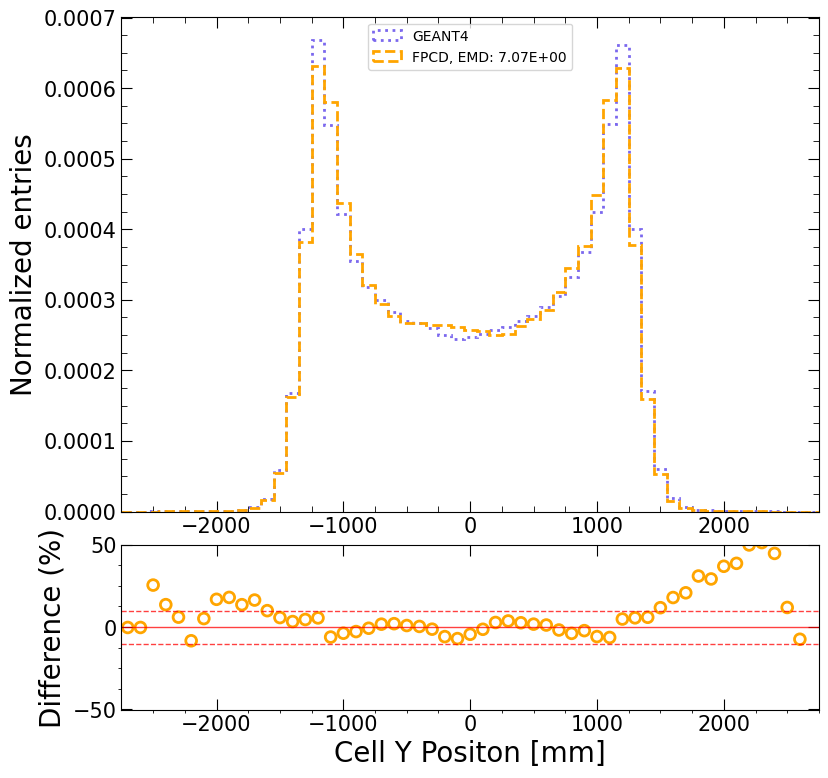

In [13]:
g4_cellsY = np.ravel(g4['hcal_cells'][:nevts,:,2])[G4_MASK]
dfsn_cellsY = np.ravel(dfsn['cell_features'][:,:,2])[DF_MASK]

#cellsY_bins = np.linspace(-2000,2000,40)
cellsY_bins = bin_dict['edgesY']
ax0,ax1 = plot_macro(g4_cellsY,dfsn_cellsY,cellsY_bins,"Cell Y Positon [mm]")
ax0.legend(loc='upper center')
plt.savefig("Y_PointClouds.pdf")

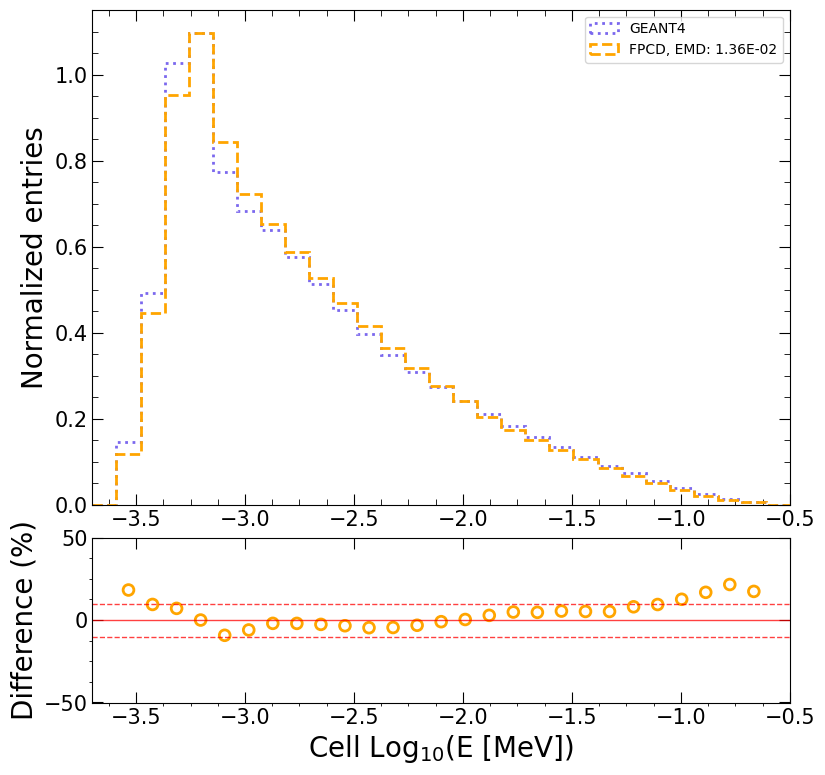

In [14]:
g4_cellsE = np.log10(np.ravel(g4['hcal_cells'][:nevts,:,0])[G4_MASK])
dfsn_cellsE = np.ravel(dfsn['cell_features'][:,:,0])[DF_MASK]

cellsE_bins = np.linspace(-3.7,-0.5,30)
ax0,ax1 = plot_macro(g4_cellsE,dfsn_cellsE,cellsE_bins,"Cell Log$_{10}$(E [MeV])")
plt.savefig("E_PointClouds.pdf")

/tmp/ipykernel_133595/3928553169.py:55: RuntimeWarning: invalid value encountered in divide
  _ = ax1.scatter(bin_centers,(g4_avgE-df_avgE)/g4_avgE*100,label="FPCD",


(<AxesSubplot: ylabel='Mean Energy [GeV]'>,
 <AxesSubplot: xlabel='Cell Z Position', ylabel='Difference (%)'>)

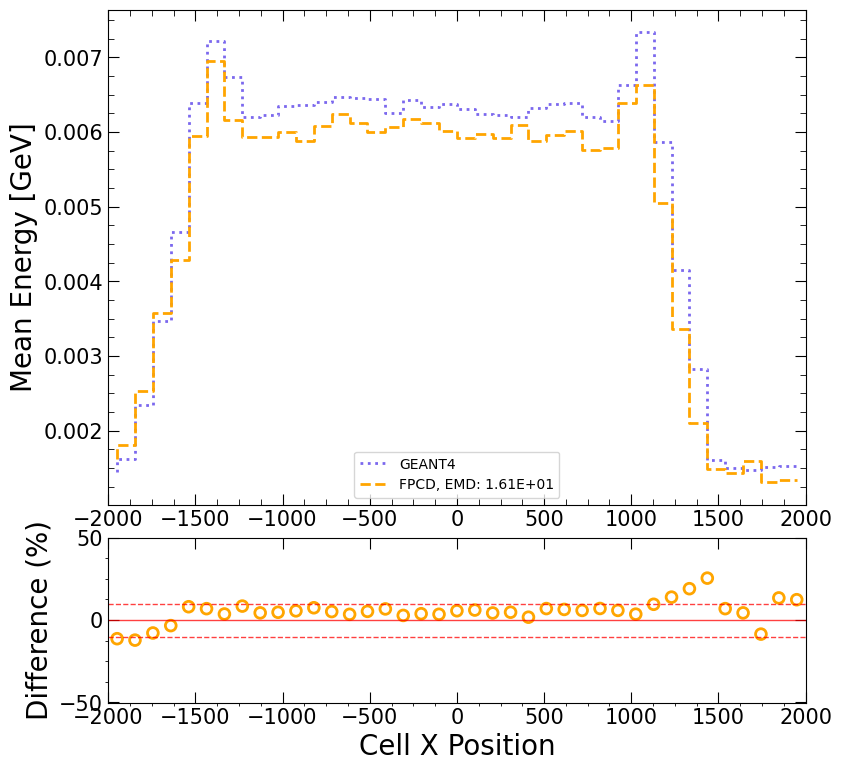

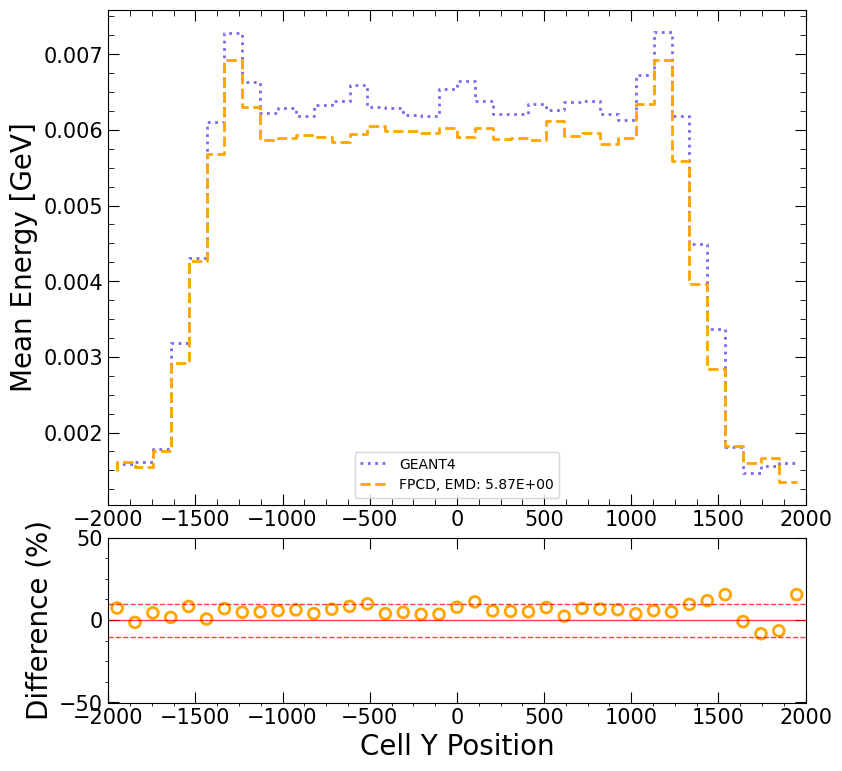

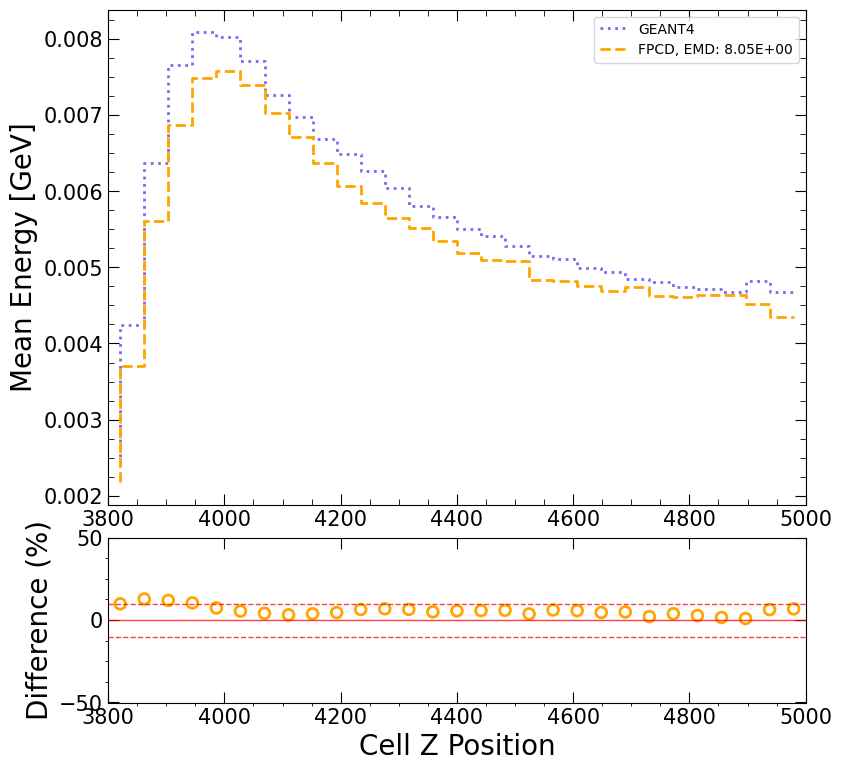

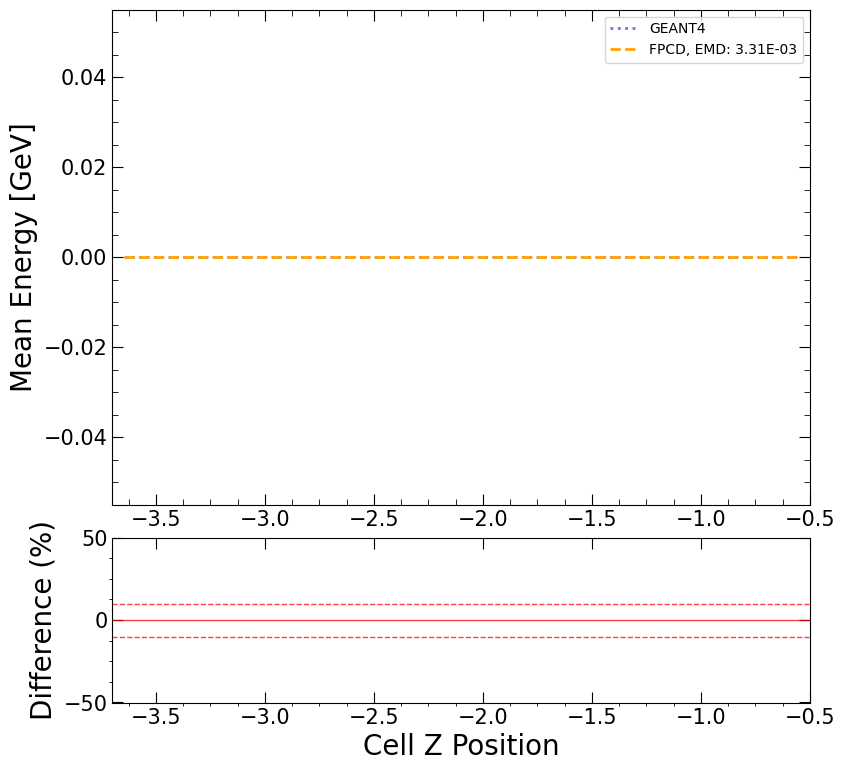

In [197]:
plot_avgE_macro(g4_cellsX,dfsn_cellsX,10**g4_cellsE,10**dfsn_cellsE,cellsX_bins,"Cell X Position")
plot_avgE_macro(g4_cellsY,dfsn_cellsY,10**g4_cellsE,10**dfsn_cellsE,cellsY_bins,"Cell Y Position")
plot_avgE_macro(g4_cellsZ,dfsn_cellsZ,10**g4_cellsE,10**dfsn_cellsE,cellsZ_bins,"Cell Z Position")

(<AxesSubplot: ylabel='Mean Energy [GeV]'>,
 <AxesSubplot: xlabel='Cell E', ylabel='Difference (%)'>)

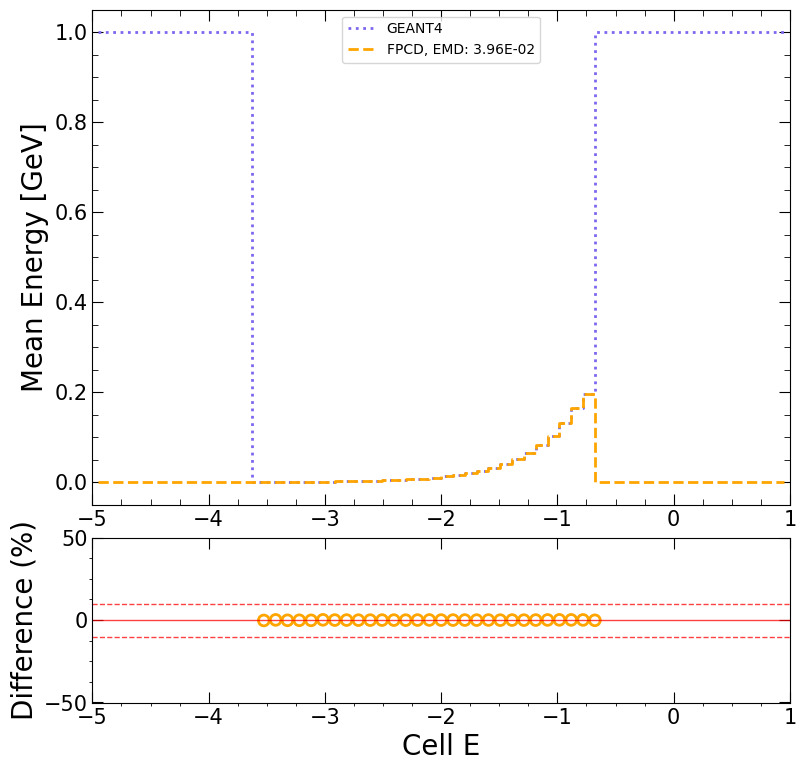

In [201]:
cellsE_bins = np.linspace(-5,1,60)
plot_avgE_macro(g4_cellsE,dfsn_cellsE,10**g4_cellsE,10**dfsn_cellsE,cellsE_bins,"Cell E")

In [6]:
print(np.shape(dfsn['cell_features']))
print(np.shape(g4['hcal_cells']))

(100000, 200, 4)
(1793500, 200, 5)


In [7]:
print(g4['hcal_cells'][:nevts,:,-1])
print(np.shape(g4['hcal_cells'][:nevts]))

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]]
(100000, 200, 5)


In [8]:
# Number of Unique Hits

In [9]:
#print(g4['hcal_cells'][100])
g4_data = g4['hcal_cells'][:nevts,:,:-1]
count_mask = g4['hcal_cells'][:nevts,:,-1]!=0
print(np.shape(g4['hcal_cells'][:nevts,:,1:-1][count_mask]))
uniques=np.unique(g4['hcal_cells'][:nevts,:,1:-1],axis=1)
counts = 0
for ivt in range(1,nevts):
    uniques = np.unique(g4_data[ivt,:,1:],axis=0)
    #print(ivt,uniques)
    counts += np.shape(uniques)[0]-1 #always includes one masked event
    
print(counts)
print(f"{counts} / {np.shape(g4_data[count_mask])[0]}")

(5240327, 3)
5240258
5240258 / 5240327


In [10]:
#print(g4['hcal_cells'][100])
dfsn_data = dfsn['cell_features'][:nevts,:,:]
count_mask = dfsn['cell_features'][:nevts,:,-1]!=0
print(np.shape(dfsn['cell_features'][:nevts,:,1:][count_mask]))
uniques=np.unique(dfsn['cell_features'][:nevts,:,1:],axis=1)
counts = 0
for ivt in range(1,nevts):
    uniques = np.unique(dfsn_data[ivt,:,1:],axis=0)
    #print(np.shape(dfsn_data[ivt,:,1:]))
    #print(ivt,uniques)
    counts += np.shape(uniques)[0]-1 #always includes one masked event

print(counts)
print(f"{counts} / {np.shape(dfsn_data[count_mask])[0]}")


(5228052, 3)
5227991
5227991 / 5228052


In [11]:
MASK = g4['hcal_cells'][:nevts,:,-1]!=0
MASK = np.ravel(MASK)


In [12]:
print(MASK[-10:])

[False False False False False False False False False False]


In [13]:
g4_cellsE = np.ravel(g4['hcal_cells'][:nevts,:,0])
dfsn_cellsE = np.ravel(dfsn['cell_features'][:,:,0])

mask = g4_cellsE != 0.0
mask_dfsn = dfsn_cellsE != 0

np.log10(g4_cellsE[mask])

array([-3.380206 , -3.1767545, -3.322421 , ..., -3.3482378, -3.2728784,
       -3.1642845], dtype=float32)

In [14]:
np.min(g4_cellsE[mask])

0.0002951767

### Cell E

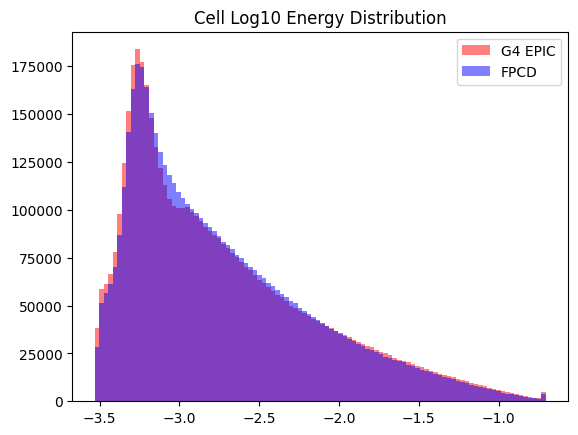

In [15]:
cellsE_bins = np.linspace(0,0.001,200)

plt.hist(np.ravel((np.log10(g4_cellsE[MASK]))),bins=100,alpha=0.5,label="G4 EPIC",color="red")
plt.hist(np.ravel(dfsn_cellsE[mask_dfsn]),bins=100,alpha=0.5,label="FPCD",color="blue")
#plt.ylim(0,0.8e7)
plt.legend()
_ = plt.title("Cell Log10 Energy Distribution")
plt.savefig("CellE.pdf")

In [16]:
import json, os
def LoadJson(file_name):
    import json,yaml
    JSONPATH = os.path.join(file_name)
    return yaml.safe_load(open(JSONPATH))

data_dict = LoadJson('../preprocessing_200.json')

def revert_logit(x):
    alpha = 1e-6
    exp = np.exp(x)
    x = exp/(1+exp)
    return (x-alpha)/(1 - 2*alpha)

def revert(x,name='cell'):
    x = x*data_dict['std_{}'.format(name)] + data_dict['mean_{}'.format(name)]
    x = revert_logit(x)
    x = x * (np.array(data_dict['max_{}'.format(name)]) -data_dict['min_{}'.format(name)]) + data_dict['min_{}'.format(name)]
    return x

In [17]:
dfsn_cells = dfsn['cell_features'][:,:,:]

(100000, 200)


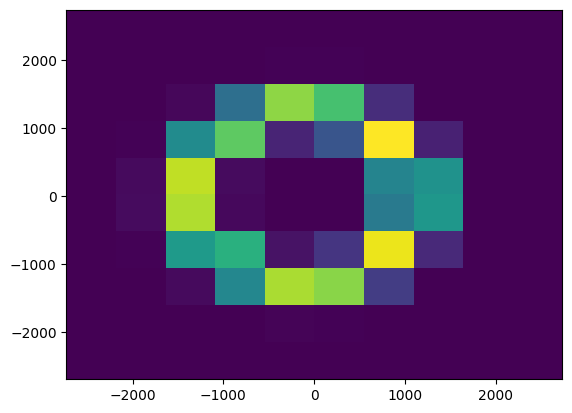

In [18]:
g4_cellsX = g4['hcal_cells'][:nevts,:,1]
g4_cellsY = g4['hcal_cells'][:nevts,:,2]
g4_cellsZ = g4['hcal_cells'][:nevts,:,3]
g4_cellsE = g4['hcal_cells'][:nevts,:,0]

test_MASK = g4['hcal_cells'][:nevts,:,-1] == 1
print(np.shape(g4_cellsX))
masked_X = g4_cellsX[test_MASK]
masked_Y = g4_cellsY[test_MASK]
masked_Z = g4_cellsZ[test_MASK]
masked_E = g4_cellsE[test_MASK]

_ = plt.hist2d(np.ravel(masked_X),np.ravel(masked_Y))

### Cell X

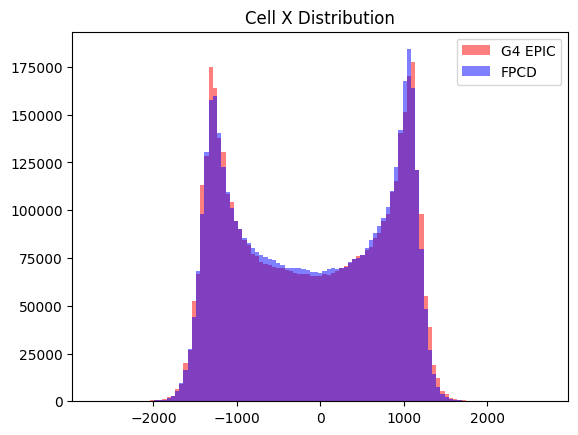

In [19]:
g4_cellsX = np.ravel(g4['hcal_cells'][:nevts,:,1])
dfsn_cellsX = np.ravel(dfsn['cell_features'][:,:,1])
dfsn_cellsZ = np.ravel(dfsn['cell_features'][:,:,3])

g4_cellsX = g4_cellsX[MASK]
dfsn_cellsX = dfsn_cellsX[dfsn_cellsZ != 0] #Z will not be zero unless masked. X can be zero

#cellsE_bins = np.linspace(0,0.001,1000)
x_bins = np.linspace(-2700,2700,108)
plt.hist(np.ravel(g4_cellsX),bins=x_bins,alpha=0.5,label="G4 EPIC",color="red",density=False)
plt.hist(np.ravel(dfsn_cellsX),bins=x_bins,alpha=0.5,label="FPCD",color="blue",density=False)
plt.legend()

_ = plt.title("Cell X Distribution")
plt.savefig("CellX.pdf")

### Cell Y

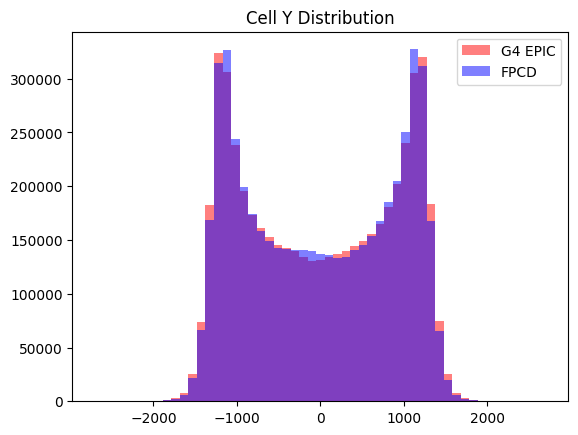

In [20]:
g4_cellsY = np.ravel(g4['hcal_cells'][:nevts,:,2])
dfsn_cellsY = np.ravel(dfsn['cell_features'][:,:,2])

g4_cellsY = g4_cellsY[MASK]
dfsn_cellsY = dfsn_cellsY[dfsn_cellsZ != 0]

y_mask = np.abs(dfsn_cellsY)>=100

#cellsE_bins = np.linspace(0,0.001,1000)
y_bins = np.linspace(-2700,2700,54)
plt.hist(np.ravel(g4_cellsY),bins=y_bins,alpha=0.5,label="G4 EPIC",color="red")
plt.hist(np.ravel(dfsn_cellsY),bins=y_bins,alpha=0.5,label="FPCD",color="blue")
plt.legend()
_ = plt.title("Cell Y Distribution")
plt.savefig("CellY.pdf")

### Cell Z

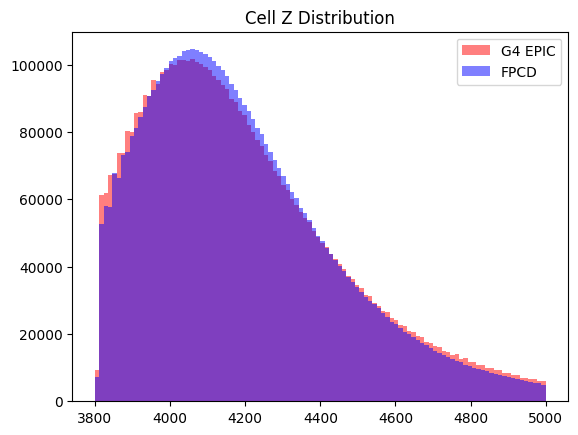

In [21]:
g4_cellsZ = np.ravel(g4['hcal_cells'][:nevts,:,3])
dfsn_cellsZ = np.ravel(dfsn['cell_features'][:,:,3])

g4_cellsZ = g4_cellsZ[g4_cellsZ != 0]
dfsn_cellsZ = dfsn_cellsZ[dfsn_cellsZ != 0]

cellsz_bins = np.linspace(3800,5000,105)
plt.hist(np.ravel(g4_cellsZ),bins=cellsz_bins,alpha=0.5,label="G4 EPIC",color="red")
plt.hist(np.ravel(dfsn_cellsZ),bins = cellsz_bins, alpha=0.5,label="FPCD",color="blue")
plt.legend()
#plt.ylim(0,0.04e7)
_ = plt.title("Cell Z Distribution")
plt.savefig("CellZ.pdf")

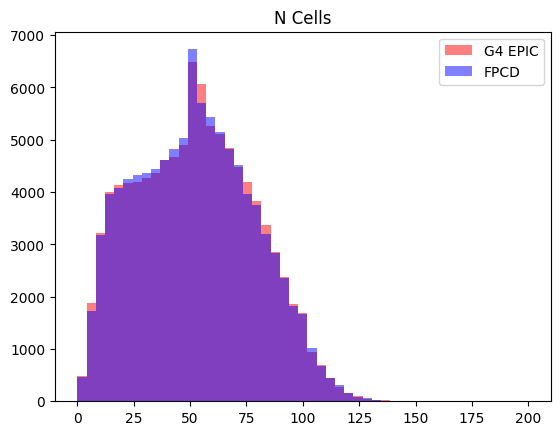

In [22]:
g4_NCells = np.ravel(g4['cluster'][:nevts,-1])
dfsn_NCells = np.ravel(dfsn['cluster_features'][:,-1])
                     
e_bins = np.logspace(-3,1, 10)
e_bins = np.linspace(0,200)
plt.hist(np.ravel(g4_NCells),alpha=0.5,bins=e_bins,label="G4 EPIC",color="red")
plt.hist(np.ravel(dfsn_NCells),alpha=0.5,bins=e_bins,label="FPCD",color="blue")
#plt.xscale('log')
plt.legend()
plt.title("N Cells")
plt.savefig("NCells_Condition.pdf")

NameError: name 'emd_hits' is not defined

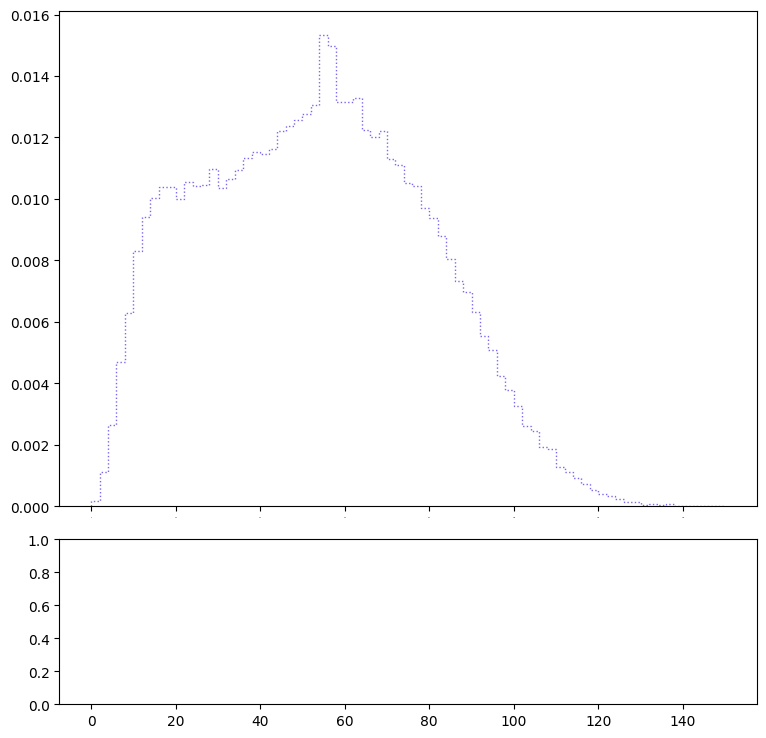

In [24]:
g4_NCells = np.ravel(g4['cluster'][:nevts,-1])
dfsn_NCells = np.ravel(dfsn['cluster_features'][:,-1])


fig,gs = SetGrid()
ax0 = plt.subplot(gs[0])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[1],sharex=ax0)

hit_bins = np.linspace(0,150,76)
g4_counts = ax0.hist(g4_NCells,bins=hit_bins,label="GEANT4",
                     color="mediumslateblue",histtype='step',
                     linestyle='dotted',density=True)

df_counts = ax0.hist(dfsn_NCells,bins=hit_bins,density=True)

df_counts = ax0.hist(dfsn_NCells,bins=hit_bins,label="FPCD, EMD: %1.4f"%(emd_hits),
                     color="orange",histtype='step',linestyle="dashed",density=True)
#ax0.set_title("Distribution of All Hits")
ax0.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
ax0.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
ax0.set_ylabel("Normalized entries",fontsize=20)
#ax0.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax0.xaxis.set_minor_locator(ticker.MultipleLocator(5))
#ax0.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax0.yaxis.set_minor_locator(ticker.MultipleLocator(0.0005))

ax0.legend()
ax0.set_xlim(0,150)


g4_counts = np.asarray(g4_counts[0])
g4_counts = np.where(g4_counts == 0, 1.0, g4_counts)
df_counts = np.asarray(df_counts[0])
bin_centers = np.linspace(0.5,149.5,75)
#emd_hits = EMD(g4_NCells,df_NCells)
emd_hits = EMD(g4_counts,df_counts)
print(emd_hits)
#ax0.text(f"EMD")

_ = ax1.scatter(bin_centers,(g4_counts-df_counts)/g4_counts*100,label="FPCD",color="orange",linestyle="dashed")

#Ticks
ax1.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
ax1.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(10))

ax1.set_ylim(-50.1,50.1)
ax1.set_ylabel("Difference (%)",fontsize=20)
ax1.set_xlabel("Number of hits",fontsize=20)

#Diff Lines
ax1.hlines(10,0,200,color='red',linestyle = '--',alpha=0.75,linewidth=1)
ax1.hlines(0,0,200,color='red',linestyle = '-',alpha=0.75,linewidth=1)
ax1.hlines(-10,0,200,color='red',linestyle = '--',alpha=0.75,linewidth=1)

plt.savefig("All_Hits.pdf")

In [ ]:
#print(g4['hcal_cells'][100])
dfsn_data = dfsn['cell_features'][:nevts,:,:]
count_mask = dfsn['cell_features'][:nevts,:,-1]!=0
print(np.shape(dfsn['cell_features'][:nevts,:,1:][count_mask]))
uniques=np.unique(dfsn['cell_features'][:nevts,:,1:],axis=1)
counts = 0
dfsn_unique_nhits = []
for ivt in range(1,nevts):
    uniques = np.unique(dfsn_data[ivt,:,1:],axis=0)
    #print(np.shape(dfsn_data[ivt,:,1:]))
    #print(ivt,uniques)
    nhits_evt = np.shape(uniques)[0]-1 #always includes one masked event
    counts += nhits_evt
    dfsn_unique_nhits.append(nhits_evt)

print(counts)
print(f"{counts} / {np.shape(dfsn_data[count_mask])[0]}")

In [ ]:
#print(g4['hcal_cells'][100])
g4_data = g4['hcal_cells'][:nevts,:,:-1]
count_mask = g4['hcal_cells'][:nevts,:,-1]!=0
print(np.shape(g4['hcal_cells'][:nevts,:,1:-1][count_mask]))
uniques=np.unique(g4['hcal_cells'][:nevts,:,1:-1],axis=1)
counts = 0
g4_unique_nhits = []
for ivt in range(1,nevts):
    uniques = np.unique(g4_data[ivt,:,1:],axis=0)
    #print(ivt,uniques)
    nhits_evt = np.shape(uniques)[0]-1 #always includes one masked event
    counts += nhits_evt
    g4_unique_nhits.append(nhits_evt)
    
print(counts)
print(f"{counts} / {np.shape(g4_data[count_mask])[0]}")

In [ ]:
g4_unique_nhits = np.asarray(g4_unique_nhits)
dfsn_unique_nhits = np.asarray(dfsn_unique_nhits)

In [ ]:
print((g4_unique_nhits-dfsn_unique_nhits)/g4_unique_nhits)

In [ ]:
print(len(g4_counts))
#bin_centers = (hit_bins[1:] - hit_bins[0:-1])/2
#print((bin_centers))
#print(hit_bins)
bin_centers = np.linspace(0.5,174.5,174)
print(bin_centers)

In [ ]:
print(bin_centers)
print(hit_bins)
print(len(g4_counts))

In [ ]:
import matplotlib.ticker as ticker
from scipy.stats import wasserstein_distance as EMD #Earth Movers Distance
fig,gs = SetGrid()
ax0 = plt.subplot(gs[0])
plt.xticks(fontsize=0)
ax1 = plt.subplot(gs[1],sharex=ax0)

hit_bins = np.linspace(0,150,76)
g4_counts = ax0.hist(g4_unique_nhits,bins=hit_bins,label="GEANT4",
                     color="mediumslateblue",histtype='step',
                     linestyle='dotted',density=True)

df_counts = ax0.hist(dfsn_unique_nhits,bins=hit_bins,label="FPCD, EMD: %1.4f"%(emd_hits),
                     color="orange",histtype='step',linestyle="dashed",density=True)
ax0.set_title("Distribution of Hits with Unique XYZ")
ax0.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
ax0.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
#ax0.xaxis.set_major_locator(ticker.MultipleLocator(20))
#ax0.xaxis.set_minor_locator(ticker.MultipleLocator(5))
#ax0.yaxis.set_major_locator(ticker.MultipleLocator(500))
ax0.yaxis.set_minor_locator(ticker.MultipleLocator(0.0005))

ax0.legend()
ax0.set_xlim(0,150)


g4_counts = np.asarray(g4_counts[0])
g4_counts = np.where(g4_counts == 0, 1.0, g4_counts)
df_counts = np.asarray(df_counts[0])
bin_centers = np.linspace(0.5,149.5,75)
emd_hits = EMD(g4_unique_nhits,dfsn_unique_nhits)
emd_hits = EMD(g4_counts,df_counts)
print(emd_hits)
#ax0.text(f"EMD")

_ = ax1.scatter(bin_centers,(g4_counts-df_counts)/g4_counts*100,label="FPCD",color="orange",linestyle="dashed")

#Ticks
ax1.tick_params(axis='both',which="major",direction='in',top=True,right=True,labelsize=15,length=8)
ax1.tick_params(axis='both',which="minor",direction='in',top=True,right=True,labelsize=15,length=4)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(5))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(10))

ax1.set_ylim(-50.1,50.1)
ax1.set_ylabel("Difference (%)",fontsize=12)

#Diff Lines
ax1.hlines(10,0,200,color='red',linestyle = '--',alpha=0.75,linewidth=1)
ax1.hlines(0,0,200,color='red',linestyle = '-',alpha=0.75,linewidth=1)
ax1.hlines(-10,0,200,color='red',linestyle = '--',alpha=0.75,linewidth=1)

plt.savefig("Unique_Hits.pdf")

In [ ]:

print(np.any(g4_counts == 0))
print(g4_counts)

In [ ]:
def quick_x(y,Q2):
    Eo = 27.5 #GeV
    Ep = 920 #GeV
    xEp = Q2/(4*Eo*y)
    x = xEp/Ep
    
    return x

In [ ]:
Q2max=500
Q2min=150

ymin = 0.2
ymax=0.7

x_max = quick_x(ymin,Q2max)
x_min = quick_x(ymax,Q2min)
x_avg = quick_x((ymax-ymin)/2,150)

print(x_min,x_max)
print(x_avg)

In [ ]:
g4_Esum = np.ravel(g4['cluster'][:nevts,3])
dfsn_Esum = np.ravel(dfsn['cluster_features'][:,-1])
#dfsn_Esum = np.ravel(dfsn['truth_features'][:,-1])
im_name = "../epic_hcal_images_5x5.h5"
im = h5py.File(im_name, 'r')
im_data = im['calo_images'][:nevts]
                       
plt.hist(np.ravel(g4_Esum),bins=np.linspace(0,200,25),alpha=0.5,label="G4 EPIC",color="red")
plt.hist(np.ravel(dfsn_Esum),bins=np.linspace(0,200,25),alpha=0.5,label="FPCD",color="blue")
plt.legend()
plt.title("Number of Cells")
plt.savefig("NCells.pdf")

In [ ]:
im_name = "../epic_hcal_images_5x5.h5"
im = h5py.File(im_name, 'r')
im_data = im['calo_images'][:nevts]
print(np.shape(im_data))
im_counts = im_data.sum(-1).sum(-1).sum(-1)
print(np.shape(im_counts))

g4_Esum = np.ravel(g4['cluster'][:nevts,2])
dfsn_Esum = np.ravel(dfsn['cluster_features'][:,-1])
    
e_bins = np.logspace(-2,0.31, 20)
#e_bins = np.linspace(0.0,30, 30)
plt.hist(np.ravel(g4_Esum),bins=e_bins,alpha=0.5,label="G4 EPIC",color="red",histtype='step')
plt.hist(np.ravel(dfsn_Esum),bins=e_bins,alpha=0.5,label="FPCD",color="blue",histtype='step')
plt.hist(np.ravel(im_counts),bins=e_bins,alpha=0.5,label="Images",color="green",histtype='step')
plt.xscale('log')
plt.legend()
plt.title("CLUSTER Energy Sums")
plt.savefig("E_Sums.pdf")

In [ ]:
im_name = "../epic_hcal_images_5x5.h5"
im = h5py.File(im_name, 'r')
im_data = np.reshape(im['calo_images'][:nevts],(nevts,-1))
im_counts = np.count_nonzero(im_data,axis=-1)


#im_name = "../G4_epic_hcal_images_5x5.h5.h5"
im = h5py.File(im_name, 'r')
im_data = np.reshape(im['calo_images'][:nevts],(nevts,-1))
g4_counts = np.count_nonzero(im_data,axis=-1)

im_name = "../GSGM_epic_hcal_images_5x5.h5"
im = h5py.File(im_name, 'r')
im_data = np.reshape(im['calo_images'][:nevts],(nevts,-1))
diff_counts = np.count_nonzero(im_data,axis=-1)




g4_Esum = np.ravel(g4['cluster'][:nevts,2])
dfsn_Esum = np.ravel(dfsn['cluster_features'][:,-1])

g4_Esum 
    
#e_bins = np.logspace(-2,0.31, 20)
e_bins = np.linspace(0.0,30, 30)
#plt.hist(np.ravel(g4_Esum),bins=e_bins,alpha=0.5,label="G4 EPIC",color="red",histtype='step')
#plt.hist(np.ravel(dfsn_Esum),bins=e_bins,alpha=0.5,label="FPCD",color="blue",histtype='step')
plt.hist(np.ravel(im_counts),bins=e_bins,alpha=0.5,label="Images",color="green",histtype='step')

#plt.hist(np.ravel(counts),bins=e_bins,alpha=0.5,label="G4",color="red",histtype='step')

plt.hist(np.ravel(diff_counts),bins=e_bins,alpha=0.5,label="FPCD",color="blue",histtype='step')

#plt.xscale('log')
plt.legend()
plt.title("Non-Zero Image Hits")
plt.savefig("E_Sums.pdf")

In [ ]:
print(np.sum(diff_counts))
print(np.sum(im_counts))